# Image Pre-processing for Nighttime Headlight Glares

Some of the popular approaches experimented in this notebook inspired by [this paper](https://www.ijariit.com/manuscripts/v4i2/V4I2-1789.pdf):
- [Gamma Adjustment](https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html)
- [Histogram Equalization](https://docs.opencv.org/3.4/d4/d1b/tutorial_histogram_equalization.html) 
- [CLAHE(Adaptive Histogram Equalization)](http://amroamroamro.github.io/mexopencv/opencv/clahe_demo_gui.html#3)
- [Simple Blob Detection/Masking(may work well for headlight detection but not for correction)](https://learnopencv.com/blob-detection-using-opencv-python-c/)
- [Inpainting(similar to blob detection but performs BETTER):](https://docs.opencv.org/4.5.2/df/d3d/tutorial_py_inpainting.html)

Unfortunately, **NO** significant improvement has been found using the above mentioned approaches. 

That being said, however, they could potentially be useful processing methods for other purposes/in other scenarios(e.g. Blurring out human faces/vehicle plates, etc). The **inpainting** method has been found to work the best in terms of finding the glare blobs and blurring them out, yet it would also smooth out the features of cars. 

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

# Declaring path variables
cwd = '../data/'
dir_cam1 = 'dssg_jpg_1/'
dir_cam2 = 'dssg_jpg_2/'
dir_cam3 = 'dssg_jpg_3/'
dir_processed = 'pre-processed/'
dir_results = 'night-detection-results/'

# Loading image files
image_rgb = cv2.imread(cwd + dir_cam1 + '2020-12-03-01-22-42-enc_104_140_cam1.jpg')
image = cv2.imread(cwd + dir_cam1 + '2020-12-03-01-22-42-enc_104_140_cam1.jpg', cv2.IMREAD_GRAYSCALE)

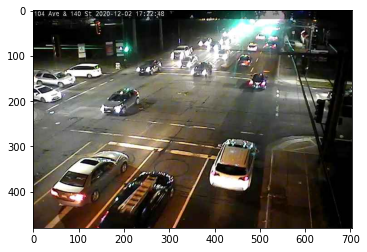

In [4]:
# Original RGB image
plt.imshow(cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB))

# **Gamma Adjustment**

In [115]:
def adjustGamma(path):
  from skimage import exposure

  image = cv2.imread(path)
  image_gamma_corrected = exposure.adjust_gamma(image, 2) # the gamma parameter can be tuned here
  plt.imshow(cv2.cvtColor(image_gamma_corrected, cv2.COLOR_BGR2RGB))
  plt.show()
  return image_gamma_corrected

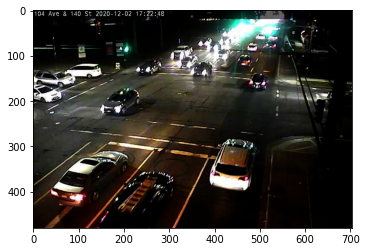

In [117]:
image_gamma_corrected = adjustGamma(cwd + dir_cam1 + '2020-12-03-01-22-42-enc_104_140_cam1.jpg')

In [118]:
# Save the image to local
cv2.imwrite (cwd + dir_processed + 'sample8_gamma.jpg', image_gamma_corrected)

True

# **Histogram Equalization**

In [63]:
def adjustHist(path):
  from skimage import exposure

  image = cv2.imread(path)
  image_rescale = exposure.rescale_intensity(image, in_range=(10, 255)) # rescale intensity
  image_hist_corrected = exposure.equalize_adapthist(image_rescale, clip_limit=0.03) # can set clip_limit to adjust contrast, range 0-1(stronger when close to 1)
  plt.imshow(image_hist_corrected)
  plt.show()
  return image_hist_corrected

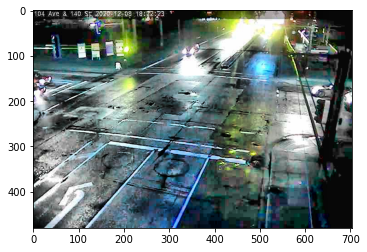

In [64]:
image_hist_corrected = adjustHist(cwd + dir_cam1 + '2020-12-09-02-22-42-enc_104_140_cam1.jpg')

In [65]:
# Save the image to local
cv2.imwrite (cwd + dir_processed + 'sample9_hist.jpg', 255*image_hist_corrected)

True

#  CLAHE 
CLAHE is a variant of Adaptive histogram equalization (AHE) which takes care of over-amplification of the contrast. CLAHE operates on small regions in the image, called tiles, rather than the entire image.

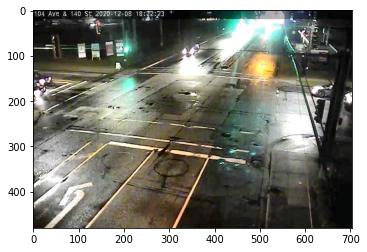

In [66]:
image_lab = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2LAB)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
image_lab[...,0] = clahe.apply(image_lab[...,0])
image_bgr = cv2.cvtColor(image_lab, cv2.COLOR_LAB2BGR)
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))

In [67]:
cv2.imwrite(cwd + dir_processed + 'sample9_clahe.jpg', image_bgr)

True

## **Comments**: 
The previous approaches do not work so well as expected as they would adjust the **contrast** of the whole image, which doesn't improve much on removing the glares. 

# **Simple Blob Detection**

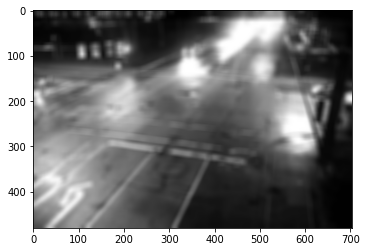

In [68]:
# Smoothing the image to reduce noises and get better peaks
image_gauss = cv2.GaussianBlur(image, (15,15), sigmaX=7, sigmaY=7, borderType = cv2.BORDER_DEFAULT)
plt.imshow(cv2.cvtColor(image_gauss, cv2.COLOR_BGR2RGB))

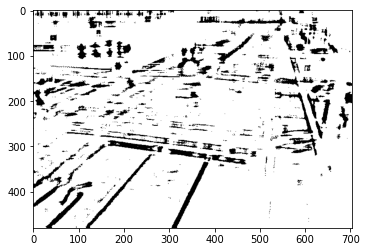

In [69]:
# Adaptive thresholding
image_thresh_adapt = cv2.adaptiveThreshold(image_gauss, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 13, -1)
plt.imshow(cv2.cvtColor(image_thresh_adapt, cv2.COLOR_BGR2RGB))

In [87]:
# Set up the SimpleBlobdetector with default parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 200
params.maxThreshold = 256

# Filter by Area.
params.filterByArea = True
params.minArea = 3.14159 *6.0 *6.0;
params.maxArea = 3.14159 * 12.0 * 12.0;

# Filter by Color (black=0)
params.filterByColor = True
params.blobColor = 0

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.5
params.maxCircularity = 1

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.5
params.maxConvexity = 1

# Filter by InertiaRatio
params.filterByInertia = True
params.minInertiaRatio = 0
params.maxInertiaRatio = 1

# Distance Between Blobs
params.minDistBetweenBlobs = 0

In [88]:
# Detecting blob's keypoints(center)
detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(image_thresh_adapt)

# Get keypoint locations and radius
for keypoint in keypoints:
   x = int(keypoint.pt[0])
   y = int(keypoint.pt[1])
   s = keypoint.size
   r = int(math.floor(s/2))
   print (x,y,r)

279 305 7
626 172 10
187 122 8
333 91 8
589 81 8
166 73 8
44 60 7
617 38 8
69 9 6


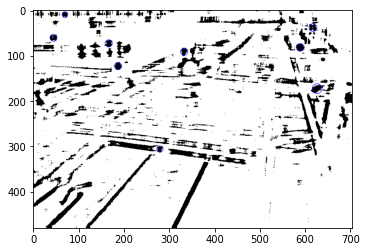

In [89]:
# Draw keypoints in circles
image_blobs = cv2.drawKeypoints(image_thresh_adapt, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(image_blobs)

In [90]:
# Get an array of keypoint coordinates
keypoints_arr = np.asarray(keypoints)
coordinates = np.zeros((keypoints_arr.shape[0], 3), dtype=np.uint8)
for i in range(0, keypoints_arr.shape[0]):
  xcoord = int(keypoints[i].pt[0])
  ycoord = int(keypoints[i].pt[1])
  radius = int(math.floor(keypoints[i].size/2))
  coordinates[i] = np.asarray([xcoord, ycoord, radius])
print(coordinates)

[[ 23  49   7]
 [114 172  10]
 [187 122   8]
 [ 77  91   8]
 [ 77  81   8]
 [166  73   8]
 [ 44  60   7]
 [105  38   8]
 [ 69   9   6]]


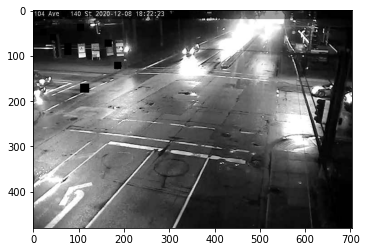

In [91]:
# Set a black mask to over-exposed blobs
image_blob_corrected = image
for coord in coordinates:
  for i in range(coord[1] - coord[2], coord[1] + coord[2]):
    for j in range(coord[0] - coord[2], coord[0] + coord[2]):
      image_blob_corrected[i, j] = 0

plt.imshow(cv2.cvtColor(image_blob_corrected, cv2.COLOR_BGR2RGB))

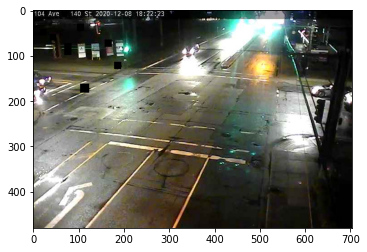

In [92]:
# Apply the blob mask on the original image
res = cv2.bitwise_and(image_rgb,image_rgb,mask = image_blob_corrected)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

In [93]:
# save the image to local
cv2.imwrite (cwd + dir_processed + 'sample9_blob.jpg', res)

True

# **Inpainting**
Reference: https://rcvaram.medium.com/glare-removal-with-inpainting-opencv-python-95355aa2aa52

In [108]:
def create_mask(image):
    import skimage.measure as measure
    gray = cv2.cvtColor( image, cv2.COLOR_BGR2GRAY )
    blurred = cv2.GaussianBlur( gray, (3,3), 0 )
    _,thresh_img = cv2.threshold( blurred, 180, 255, cv2.THRESH_BINARY)
    thresh_img = cv2.erode( thresh_img, None, iterations=2 )
    thresh_img  = cv2.dilate( thresh_img, None, iterations=3 )
    # perform a connected component analysis on the thresholded image,
    # then initialize a mask to store only the "large" components
    labels = measure.label( thresh_img, connectivity=2, background=0 )
    mask = np.zeros( thresh_img.shape, dtype="uint8" )
    # loop over the unique components
    for label in np.unique( labels ):
        # if this is the background label, ignore it
        if label == 0:
            continue
        # otherwise, construct the label mask and count the
        # number of pixels
        labelMask = np.zeros( thresh_img.shape, dtype="uint8" )
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero( labelMask )
        # if the number of pixels in the component is sufficiently
        # large, then add it to our mask of "large blobs"
        if numPixels > 300:
            mask = cv2.add( mask, labelMask )
    return mask

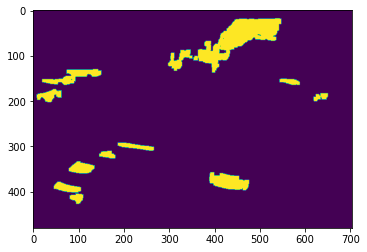

In [109]:
mask = create_mask(image_rgb)
plt.imshow(mask)

In [110]:
# Get the inverse mask to visualize the blobs
mask_inverted = ~mask
with np.printoptions(threshold=np.inf):
    print(mask_inverted)

[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 

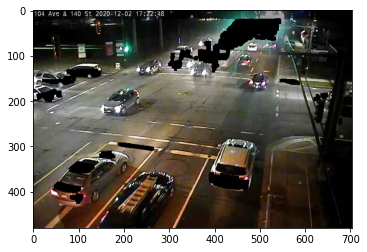

In [111]:
# Visualization of the blobs
res_2 = cv2.bitwise_and(image_rgb,image_rgb,mask = mask_inverted)
plt.imshow(cv2.cvtColor(res_2, cv2.COLOR_BGR2RGB))

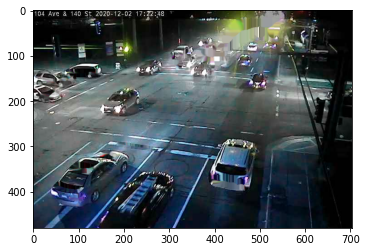

In [112]:
# Apply in-painting to the image blobs with glares
image_inpaint_corrected = cv2.inpaint( image_rgb, mask, 0.01, cv2.INPAINT_NS)
plt.imshow(image_inpaint_corrected)

In [113]:
cv2.imwrite (cwd + dir_processed + 'sample8_inpaint.jpg', image_inpaint_corrected)

True

# **Results of the processed images VS original image**

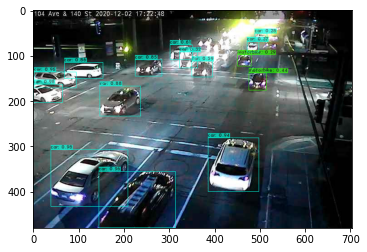

In [5]:
# Original detection result
plt.imshow(cv2.imread(cwd + dir_results + 'sample8_original_v4.jpg'))

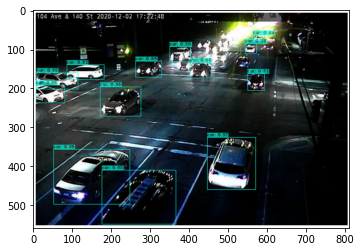

In [6]:
# After gamma correction
plt.imshow(cv2.imread(cwd + dir_results + 'sample8_gamma_v4.png'))

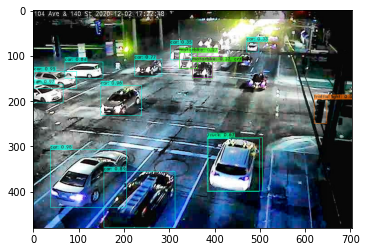

In [20]:
# After histogram equalization(constrast adjustment)
plt.imshow(cv2.imread(cwd + dir_results + 'sample8_hist_v4.jpg'))

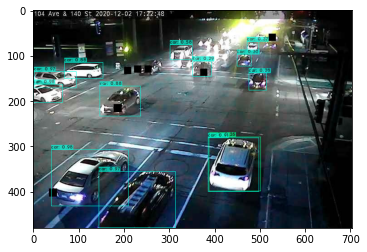

In [21]:
# After blob masking
plt.imshow(cv2.imread(cwd + dir_results + 'sample8_v4.jpg'))

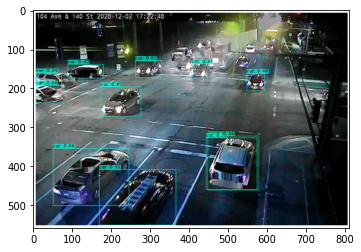

In [7]:
# After inpainting
plt.imshow(cv2.imread(cwd + dir_results + 'sample8_inpaint_v4.png'))

# References